# Final Project Baseline
**Project:** Facial Keypoints Detection

**Authors:** Richard Ryu, Nick Cirella, Diana Iftimie

**Team:** RnD

### Import Libraries

In [279]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy
import skimage.filters
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend

from sklearn.model_selection import train_test_split

import tensorflow as tf

## I. Introduction & Purpose

The purpose of this project is to develop a working model for solving the core Facial Keypoints Detection problem. At a high level, Facial Keypoints Detection is a task where given a image of a human face, a model analyzes the image and detects facial keypoints for the identified face. Such facial keypoints include the centers and corners of the eyes, the corners of the mouth, and the tip of the nose, among other facial key points. To accomplish this task, the model must predict a set of coordinates (x, y) for each facial keypoint in the pixel space of the given image of a face.

As a computer vision problem, the Facial Keypoints Detection task has a wide variety of applications. From the basic task of identifying facial keypoints of a given image of a face, these results can be used to solve the task of identifying faces in images (a.k.a. facial recognition). These results then enable solving much more complex problems, including tracking (multiple) faces in videos (such as in security camera footage) and analyzing facial expressions in different faces (emotion understanding, which can be used in sentiment analysis based on camera footage). This technology can even extend to doing more complex biometrics analysis, which is heavily used to identify people simply using an image of their face, such as Microsoft's Face API & Windows Hello and Apple's Face ID for iPhones. Thus, accomplishing the facial keypoints detection task is central to much of the work done in this day and age on basic human understanding in computer vision. 

For the purpose of this project, we will focus on the Facial Keypoints Detection task as defined in the Kaggle Challenge linked here: https://www.kaggle.com/c/facial-keypoints-detection/overview/description

## II. High-Level Machine Learning Task

As mentioned above, the goal of this machine learning task is to accurately predict a set of facial keypoints as coordinates in pixel space, given an image of a face (the inference task). That is, we aim to develop a model (or multiple versions of a model) that is able to learn generalized information about the facial keypoints detection task from a training set available on the kaggle challenge for Facial Keypoints Detection. For training, our input is a set of images of faces and our output is a set of facial keypoints that correspond to each image. We will train a model that is able to generally capture the relationship between input and output data in order to accomplish the inference task of detecting keypoints given new images of faces. 

## III. The Data

As described previously, our input data consists of images, both for training and test. We will refer to both of these datasets in the context of the Kaggle competition, as "Kaggle Competition Training" and "Kaggle Competition Test", as they are specifically related to the Kaggle Competition task. This will avoid confusing the Kaggle Competition data with the subsets of Kaggle Competition Training data that we will use for actual model training, hyperparameter tuning, and evaluation. That is, for the purpose of modeling and evaluation, we will split the Kaggle Competition Training data into a train and dev sets, and leave the Kaggle Competition Test data for final evaluation (i.e. as our test set).

As a first step we will load the data to allow for easy use throughout the project, which is done below. After which, we will go into the details of the kind of data we have for this project.

In [280]:
# Load Data
def LoadData(training_data=True,):
    if (training_data):
        full_data = pd.read_csv('data/training/training.csv')
    else:
        full_data = pd.read_csv('data/test/test.csv')
    
    # Convert image column from one with space-separated pixel values to np arrays
    image_data_list = []
    for i in full_data["Image"].index:
        image_data_list.append(full_data["Image"][i].split(" "))
    image_data = np.array(image_data_list, dtype = 'float')
            
    # Extract image data & 
    # Scale image data to be between 0 and 1 (currently between 0 and 255)
    image_data = image_data / 255
    
    if (training_data):
        # Extract label data & 
        # Scale label data to have coordinates between -1 and 1 (currently between 0 and 96)
        label_data = np.array(full_data.drop(["Image"], axis=1), dtype="float")
        label_data = (label_data - 96/2) / (96/2)
        
        # Split image data & label data into train &  sets (80/20)
        train_image, dev_image, train_label, dev_label = train_test_split(image_data, label_data, 
                                                                          test_size=0.2, random_state=42, shuffle=True)
        print("Train Images Shape: " + str(train_image.shape) + "\tTrain Labels Shape: " + str(train_label.shape))
        print("Dev Images Shape: " + str(dev_image.shape) + " \t\tDev Labels Shape: " + str(dev_label.shape))
        return (train_image, train_label, dev_image, dev_label)
    else:
        print("Test Images Shape: " + str(image_data.shape))
        return (image_data)

# Load all of the Kaggle training data as np arrays, as train & dev sets
train_image_data, train_label_data, dev_image_data, dev_label_data = LoadData(training_data=True)
test_image_data = LoadData(training_data = False)

Train Images Shape: (5639, 9216)	Train Labels Shape: (5639, 30)
Dev Images Shape: (1410, 9216) 		Dev Labels Shape: (1410, 30)
Test Images Shape: (1783, 9216)


### Kaggle Competition Training Data

In [281]:
# Display High-Level Kaggle Training Data
kaggle_competition_training_data = pd.read_csv('data/training/training.csv')
print("Kaggle Competition Training Data Shape: ", kaggle_competition_training_data.shape)
print("\n10 Examples from Kaggle Competition Training Data:")
kaggle_competition_training_data.head(10).T.round(3)

Kaggle Competition Training Data Shape:  (7049, 31)

10 Examples from Kaggle Competition Training Data:


0  \
left_eye_center_x                                                    66.0336   
left_eye_center_y                                                    39.0023   
right_eye_center_x                                                    30.227   
right_eye_center_y                                                   36.4217   
left_eye_inner_corner_x                                              59.5821   
left_eye_inner_corner_y                                              39.6474   
left_eye_outer_corner_x                                              73.1303   
left_eye_outer_corner_y                                                39.97   
right_eye_inner_corner_x                                             36.3566   
right_eye_inner_corner_y                                             37.3894   
right_eye_outer_corner_x                                             23.4529   
right_eye_outer_corner_y                                             37.3894   
left_eyebrow_inner_end_x                                             56.9533   
left_eyebrow_inner_end_y                                             29.0336   
left_eyebrow_outer_end_x                                             80.2271   
left_eyebrow_outer_end_y                                             32.2281   
right_eyebrow_inner_end_x                                            40.2276   
right_eyebrow_inner_end_y                                            29.0023   
right_eyebrow_outer_end_x                                            16.3564   
right_eyebrow_outer_end_y                                            29.6475   
nose_tip_x                                                           44.4206   
nose_tip_y                                                           57.0668   
mouth_left_corner_x                                                  61.1953   
mouth_left_corner_y                                                  79.9702   
mouth_right_corner_x                                                 28.6145   
mouth_right_corner_y                                                  77.389   
mouth_center_top_lip_x                                               43.3126   
mouth_center_top_lip_y                                               72.9355   
mouth_center_bottom_lip_x                                            43.1307   
mouth_center_bottom_lip_y                                            84.4858   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                           1  \
left_eye_center_x                                                    64.3329   
left_eye_center_y                                                    34.9701   
right_eye_center_x                                                   29.9493   
right_eye_center_y                                                   33.4487   
left_eye_inner_corner_x                                              58.8562   
left_eye_inner_corner_y                                              35.2743   
left_eye_outer_corner_x                                              70.7227   
left_eye_outer_corner_y                                              36.1872   
right_eye_inner_corner_x                                             36.0347   
right_eye_inner_corner_y                                             34.3615   
right_eye_outer_corner_x                                             24.4725   
right_eye_outer_corner_y                                             33.1444   
left_eyebrow_inner_end_x                                             53.9874   
left_eyebrow_inner_end_y                                             28.2759   
left_eyebrow_outer_end_x                                             78.6342   
left_eyebrow_outer_end_y                                             30.4059   
right_eyebrow_inner_end_x                                            42.7289   
right_eyebrow_inner_end_y                                             26.1

For the Kaggle Competition Training data that is available for constructing our model, we have a total of `7049` images to consider when training our model(s). Each of thse images are `96x96` pixels in dimension, with the pixel values organized as lists of row-ordered pixel values ranging between `(0, 255)` (for a total of `9216` values) which lives in the `Image` entry of the table (the lowest row in this transposed dataframe). The structure of the pixel values is very similar to that seen in the MNIST dataset in Project 1. 

In addition to the `Image` entry with the actual image data, we see the first 30 entries correspond to 15 facial keypoints (each pair of label entries correspond to the `x` and `y` pixel coordinates of one facial keypoint). For example, the first entry indicates `left_eye_center_x` and the second entry indicates `left_eye_center_y`, which in combination correspond to coodinates (`x`, `y`) of the facial keypoint for the center of the left eye.

With this data, we have both the input (images) and the correct output (facial keypoints labels) that can be used to train our model(s). In order to properly evaluate our model and keep it from overfitting, we will split this data into train, dev, and test sets.

Below is an example image and its corresponding facial keypoints (shown in red):

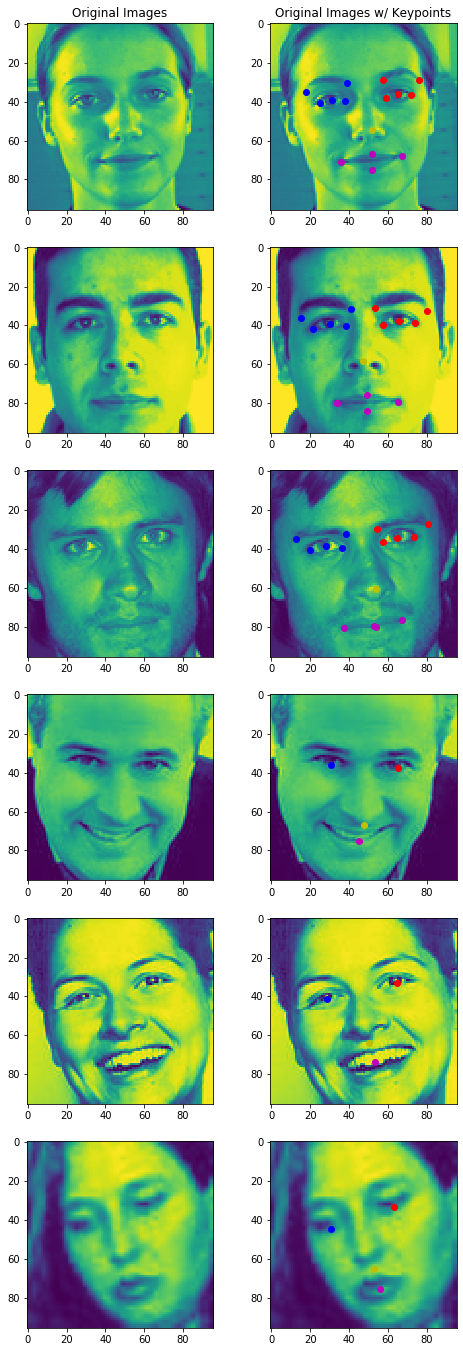

In [282]:
def ShowSampleImages(example_nums, image_data, label_data, 
                     imputed_label_data=None,
                     flipped_image_data=None, flipped_label_data=None,
                     blurred_image_data=None):
    
    # Figure out figure dimensions
    num_examples = len(example_nums)
    num_col = (2 + int(flipped_image_data is not None) + int(imputed_label_data is not None) + int(blurred_image_data is not None))
    f, images = plt.subplots(num_examples,num_col, figsize=(4*num_col,4*num_examples))

    def PrepImageData(image):
        return image.reshape(96, 96) * 255
    
    def PrepLabelData(label):
        return (label * 96/2.0) + 96/2.0
    
    def PlotExample(row, col, image, label, title):
        # Plot image
        images[row, col].imshow(PrepImageData(image))
        if (row == 0):
            images[row, col].set_title(title)
            
        # Plot keypoints over image
        if (label is not None):
            for kp_idx in range(0, 15):
                colors = ['r', 'b', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'y', 'm', 'm', 'm', 'm']
                if (not np.isnan(label[2 * kp_idx])):
                    images[row, col].plot(PrepLabelData(label[2 * kp_idx]), 
                                          PrepLabelData(label[2 * kp_idx + 1]), 'o', color=colors[kp_idx])
    
    for j in range(0, num_examples):
        example_idx = example_nums[j]
        
        # Plot original image with no keypoints
        PlotExample(j, 0, image_data[example_idx], None, "Original Images")

        # Plot image with original facial keypoints
        PlotExample(j, 1, image_data[example_idx], label_data[example_idx], "Original Images w/ Keypoints")
        
        idx = 1 # current idx filled in for plotting samples
        
        if (imputed_label_data is not None):
            # Plot image with imputed facial keypoints
            idx = idx + 1
            PlotExample(j, idx, image_data[example_idx], imputed_label_data[example_idx], "Original Images w/ Imputed Keypoints")

        
        if (flipped_image_data is not None):
            # Plot flipped image with flipped facial keypoints
            idx = idx + 1
            PlotExample(j, 2, flipped_image_data[example_idx], flipped_label_data[example_idx], "Flipped Images w/ Keypoints")
        
        if (blurred_image_data is not None):
            # Plot blurred image with original facial keypoints
            idx = idx + 1
            PlotExample(j, idx, blurred_image_data[example_idx], label_data[example_idx], "Blurred Images w/ Keypoints")
            
# Display 6 examples of training data from Kaggle
example_nums= [3, 7, 4, 6, 10, 19]
ShowSampleImages(example_nums, train_image_data, train_label_data)

By simply assessing some of the examples shown above, we clearly have a case where some examples have all 15 keypoints (e.g. first three examples) whereas others having missing keypoints (e.g. last three examples). This is something that we'll need to address moving forward to ensure model quality, which is discussed in the next section.....

# IV. Improving the Data

In the previous section, we saw an exploration of the kind of dataset we have for this task. But in order to improve our dataset to come out with the best model quality, we will investigate a few potential tactics. This tactics include:
* Dealing with Missing Keypoints
* Augmenting the Dataset with Horizontal Flips
* Augmenting the Dataset with Gaussian Blur
We will discuss and apply each of these tactics in detail with the following subsections.

## Dealing with Missing Keypoints

In [283]:
kaggle_competition_training_data.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

We have quite a few examples with missing values--it would be best to understand among samples with missing keypoint values, what are the sets of keypoints that are available. Using this information, we can decide on the best way forward (whether to do imputation of missing keypoints based on all the samples that have those missing keypoints, or just fill in averages, etc).

In [284]:
# Construct encoding maps for entries with missing values
def CreateEncodingList(labels):
    encoding_list = []
    for r in range(0, len(labels)):
        row = labels[r]

        # Encode 0 if missing, 1 if present
        encoding_vec = ['0' if np.isnan(kp) else '1' for kp in row] 
        encoding = ''.join(encoding_vec)

        # Add to encoding list for all samples
        encoding_list.append(encoding)
    
    return encoding_list
    
def CreateEncodingMap(labels):
    # Get column names to note which keypoints are missing and which are present
    keypoint_names = kaggle_competition_training_data.columns[0:30]
    
    # Construct encoding for each label
    encoding_list = CreateEncodingList(labels)
    
    # Helper function for inserting into encoding map
    def insert(df, row):
        insert_loc = df.index.max()

        if pd.isna(insert_loc):
            df.loc[0] = row
        else:
            df.loc[insert_loc + 1] = row
    
    # Construct encoding map
    encodings_map = pd.DataFrame(columns = ["encoding", "num_kp_missing", "num_kp_present", "missing_kp_names", "present_kp_names", "count"])
    for r in range(0, len(labels)):
        encoding = encoding_list[r]
        label = labels[r]
        
        # Only collect those with missing values
        if ('0' in encoding):        
            # Try to get row for encoding if it exists
            #print(encodings_map['encoding'])
            if (encoding not in encodings_map.encoding.values):                
                # Compute necessary entry data
                missing_idx = np.argwhere(np.isnan(label))
                missing_kp_names = ', '.join([i[0] for i in keypoint_names[missing_idx]])
                present_idx = [i for i in range(0,30) if i not in np.argwhere(np.isnan(label))]
                present_kp_names = ', '.join([i for i in keypoint_names[present_idx]])

                # Insert entry
                insert(encodings_map,[encoding, round(len(missing_idx)/2), round(len(present_idx)/2), missing_kp_names, present_kp_names,1])
            else:
                # Get Existing Entry
                entry = encodings_map.loc[encodings_map['encoding']==encoding]
                row_num = entry.index[0]

                # Update existing count
                new_count = entry['count'].item() + 1
                encodings_map.at[row_num] = [entry['encoding'].item(), \
                                             entry['num_kp_missing'].item(), \
                                             entry['num_kp_present'].item(), \
                                             entry['missing_kp_names'].item(), \
                                             entry['present_kp_names'].item(), \
                                             new_count]
    return (encodings_map, encoding_list)
        
all_encodings_map, all_encoding_list = CreateEncodingMap(train_label_data)
all_encodings_map

# Save Results to tsv for excel analysis
# encodings_map.to_csv(path_or_buf = "encodings_map.tsv",sep='\t')

encoding num_kp_missing num_kp_present  \
0   111100000000000000001100000011             11              4   
1   111111111111111111111111001111              1             14   
2   110011110000111111111111111111              3             12   
3   111111111111111111111111111100              1             14   
4   111111111111110011001111111111              2             13   
5   111111111111111111001111111111              1             14   
6   111111111111111111111100111111              1             14   
7   111111111111111111001100000000              5             10   
8   110011110000110000111111111111              5             10   
9   111100110011000000001111111111              6              9   
10  111111111111110011111111111111              1             14   
11  111111111111111111111100000000              4             11   
12  000000000000000000001111111111             10              5   
13  111100111111111111111111111111              1             14   
14  111111111100111111001111111111              2             13   
15  110011111111111111111111111111              1             14   
16  111111001111110011001111111111              3             12   
17  111111111111111100001111111111              2             13   
18  111111111111110011111100111111              2             13   
19  111111001111111111111111111111              1             14   
20  111111110011111111111111111111              1             14   
21  111111001111110011111100000000              6              9   
22  111100000000000000001100000000             12              3   
23  001111111111000011111111111111              3             12   
24  111100001111111111111111111111              2             13   
25  111111111100111111111111001111              2             13   
26  000000000000000011001111001111             10              5   
27  000000000000111111111111111111              6              9   
28  000011111111111111111111111111              2             13   
29  111111001111110011111100111111              3             12   
30  000000000000001111111111111111              7              8   
31  111111111111111100111111111111              1             14   
32  111111111111000011111111111111              2             13   
33  001100001111111111111100111111              4             11   
34  111111001111110011111111111111              2             13   
35  111111111111111111111111110000              2             13   
36  000011111100111111111111111111              3             12   
37  111111111111000000001111111111              4             11   
38  111111111111110000001111111111              3             12   
39  111111111111001100111111111111              2             13   
40  000011110011111111111111111111              3             12   
41  111100110011111111111111111111              2             13   

                                     missing_kp_names  \
0   left_eye_inner_corner_x, left_eye_inner_corner...   
1          mouth_right_corner_x, mouth_right_corner_y   
2   right_eye_center_x, right_eye_center_y, right_...   
3   mouth_center_bottom_lip_x, mouth_center_bottom...   
4   left_eyebrow_outer_end_x, left_eyebrow_outer_e...   
5   right_eyebrow_outer_end_x, right_eyebrow_outer...   
6            mouth_left_corner_x, mouth_left_corner_y   
7   right_eyebrow_outer_end_x, right_eyebrow_outer...   
8   right_eye_center_x, right_eye_center_y, right_...   
9   left_eye_inner_corner_x, left_eye_inner_corner...   
10  left_eyebrow_outer_end_x, left_eyebrow_outer_e...   
11  mouth_left_corner_x, mouth_left_corner_y, mout...   
12  left_eye_center_x, left_eye_center_y, right_ey...   
13   left_eye_inner_corner_x, left_eye_inner_corner_y   
14  right_eye_outer_corner_x, right_eye_outer_corn...   
15             right_eye_center_x, right_eye_center_y   
16  left_eye_outer_corner_x, left_eye_outer_corner...   
17  right_eyebrow_inner_end_x, right_eyebrow_inner...   
18  left_eyebrow_o

From the results above, we have 41 different "kinds" of missing-value samples in our training set. The vast majority (3828/3947) are cases where we only have the right-center eye, left-center eye, nose tip, and mouth center-bottom lip keypoints, which can be argued to be the absolute essential keypoints. If we can compute the missing keypoints for these examples, this will give us a huge boost in training data to help with the model development.

In [285]:
# Prioritize imputing missing facial keypoints for most common case: encoding = 111100000000000000001100000011
P1_encoding = '111100000000000000001100000011'
P1_missing_kp_idx = [i for i in range(0, len(all_encoding_list)) if all_encoding_list[i] == P1_encoding]
print("Number of Priority 1 Missing Keypoints Samples: " + str(len(P1_missing_kp_idx)))

# Get the missing data using the filter index
P1_train_image_data = train_image_data[P1_missing_kp_idx]
P1_train_label_data = train_label_data[P1_missing_kp_idx]
print("Number of Priority 1 Missing Keypoints Samples: " + str(len(P1_train_image_data)))

Number of Priority 1 Missing Keypoints Samples: 3828
Number of Priority 1 Missing Keypoints Samples: 3828


To help with filling in these missing keypoints, let us leverage the structure of the data with no missing keypoints. For the P1 scenarios we're focusing on, we have 4 keypoints as our ground truth. Among the 2140 samples with no missing keypoinds, we can compute what is the avg distance (in both x and y) between the 4 types of keypoints we have in our missing samples and the other keypoints we have in our nonull samples (we will have this computed in both the x and y direction separately. 

With this information we can construct two 4x11 matrix, one for each x and y coordinate dimension, where the 4 indicies correspond to each x or y coordinate of the 4 keypoints we have in the P1 samples and the 11 indicies correspond to each x or y coordinate of the 11 keypoints we don't have in the P1 samples but do have in the nonull samples. For each cell at the column index $g$ and row index $m$, we will have an average distance in the x or y direction (depending on the average matrix) between the one of the 4 keypoint coordinates $g$ and one of the 11 missing keypoint coordinates $m$ among our nonull samples. These two matricies are computed below:

In [286]:
def ComputeAvgMatrix(labels_data, all_kp_names, existing_kp_names, missing_kp_names):
    # Construct the avg matrix for missing keypoint imputation
    avg_matrix = np.empty((len(missing_kp_names), len(existing_kp_names)), dtype='float')
    
    # Iterate through each column index for the ground truth keypoints to base avgs off of
    for g in range(0, len(existing_kp_names)):
        # Get Coordinates for ground truth keypoint we want to base avgs off of
        g_name = existing_kp_names[g]
        g_label_data_idx = all_kp_names.index(g_name)
        g_label_data_coords = labels_data[:, g_label_data_idx]
        #print("\nGround Truth Name: " + str(g_name) + ", " + str(g_label_data_idx))

        # Iteration through each row index for the missing keypoints to get avgs for
        for m in range(0, len(missing_kp_names)):
            # Get Coordinates for missing keypoints we want to compute avgs to
            m_name = missing_kp_names[m]
            m_label_data_idx = all_kp_names.index(m_name)
            m_label_data_coords = labels_data[:, m_label_data_idx]
            #print("\nMissing Name: " + str(m_name) + ", " + str(m_label_data_idx))

            # Compute average difference between ground truth coordinates and missing coordinates
            # These differences will be added to the existing coordinates when computing the missing coordinates
            diff = np.subtract(m_label_data_coords, g_label_data_coords)
            avg_diff = np.mean(diff)
            #print("diff.shape = " + str(diff.shape))

            # Update cell in our avg matrix
            avg_matrix[m, g] = avg_diff
            #print("avg_diff = " + str(avg_diff))
            
    return avg_matrix

# Get Data with no missing values for keypoints
nomissing_train_image_data = train_image_data[~np.isnan(train_label_data).any(axis=1)]
nomissing_train_label_data = train_label_data[~np.isnan(train_label_data).any(axis=1)]

# Prep data for average matrix computation
keypoint_names = kaggle_competition_training_data.columns[0:30]
all_kp_names = [i for i in keypoint_names]
all_existing_kp_names = ["left_eye_center_x",         "left_eye_center_y", 
                         "right_eye_center_x",        "right_eye_center_y", 
                         "nose_tip_x",                "nose_tip_y", 
                         "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]
all_missing_kp_names = [x for x in keypoint_names if x not in all_existing_kp_names]
        
# Compute average matrix for x coordinates (produce a 4x11 matrix)
existing_kp_names_x = [n for n in all_existing_kp_names if "_x" in n]
missing_kp_names_x = [n for n in all_missing_kp_names if "_x" in n]
avg_matrix_x_coord = ComputeAvgMatrix(nomissing_train_label_data, all_kp_names, existing_kp_names_x, missing_kp_names_x)
print("Existing Keypoint Names for x: \n" + str(existing_kp_names_x))
print("\nMissing Keypoint Names for x: \n" + str(missing_kp_names_x))
print("\nAverage Matrix for x-coordinates of Keypoints:")
print(avg_matrix_x_coord)

# Compute average matrix for y coordinates (produce another 4x11 matrix)
existing_kp_names_y = [n for n in all_existing_kp_names if "_y" in n]
missing_kp_names_y = [n for n in all_missing_kp_names if "_y" in n]
avg_matrix_y_coord = ComputeAvgMatrix(nomissing_train_label_data, all_kp_names, existing_kp_names_y, missing_kp_names_y)
print("\n\nExisting Keypoint Names for y: \n" + str(existing_kp_names_y))
print("\nMissing Keypoint Names for y: \n" + str(missing_kp_names_y))
print("\nAverage Matrix for y-coordinates of Keypoints:")
print(avg_matrix_y_coord)

Existing Keypoint Names for x: 
['left_eye_center_x', 'right_eye_center_x', 'nose_tip_x', 'mouth_center_bottom_lip_x']

Missing Keypoint Names for x: 
['left_eye_inner_corner_x', 'left_eye_outer_corner_x', 'right_eye_inner_corner_x', 'right_eye_outer_corner_x', 'left_eyebrow_inner_end_x', 'left_eyebrow_outer_end_x', 'right_eyebrow_inner_end_x', 'right_eyebrow_outer_end_x', 'mouth_left_corner_x', 'mouth_right_corner_x', 'mouth_center_top_lip_x']

Average Matrix for x-coordinates of Keypoints:
[[-0.14506908  0.61830597  0.23583999  0.23147591]
 [ 0.1497019   0.91307695  0.53061097  0.5262469 ]
 [-0.61796632  0.14540873 -0.23705724 -0.24142132]
 [-0.9151533  -0.15177825 -0.53424423 -0.5386083 ]
 [-0.21080074  0.55257431  0.17010833  0.16574426]
 [ 0.27859068  1.04196573  0.65949975  0.65513567]
 [-0.56257017  0.20080488 -0.1816611  -0.18602518]
 [-1.05251475 -0.2891397  -0.67160568 -0.67596975]
 [-0.05811984  0.70525521  0.32278924  0.31842516]
 [-0.69332682  0.07004823 -0.31241774 -0.316

With thes matricies computed, we now have two 4x11 matricies that we can use for imputation of the missing keypoints using the existing 4 keypoints. That is, we can take each coordinate of the 4 existing keypoints and add the averages from the above matricies (accordingly) to construct the missing keypoints (which we will refer to as "imputation"). This is shown below:

In [287]:
# Imputes the missing keypoints to a new matrix using the specified avg_matrix and corresponding 
# exisitng & missing keypoint names. Note that this function operates assuming one coordinate dimension at a time
# (e.g. only work with x's, so using avg_matrix_x only)
def ImputeMissingKeypoints(missing_labels_data, all_kp_names, existing_kp_names, missing_kp_names, avg_matrix):
    # Create matrix that will house new label data (including imputed missing keypoints)
    imputed_labels_data = np.copy(missing_labels_data)
    
    # Do imputation for each sample
    for sample_idx in range(0, missing_labels_data.shape[0]):
        sample = missing_labels_data[sample_idx, :]
        #print("\n\nSample # " + str(sample_idx))

        # Get all existing keypoints for the sample (to base imputation on)
        existing_kp_idxs = [all_kp_names.index(n) for n in existing_kp_names]
        existing_kps = sample[existing_kp_idxs]
        #print("\nExisting Keypoint Names = " + str(existing_kp_names))
        #print("Existing Keypoint values = " + str(existing_kps))
        
        # Iterate for each missing keypoint, as defined by missing_kp_names
        for m_kp_idx in range(0, len(missing_kp_names)):
            #print("\nExisting Keypoint Names = " + str(existing_kp_names))
            #print("Existing Keypoint values = " + str(existing_kps))
            
            # Get name and index of missing keypoint for reference
            m_kp_name = missing_kp_names[m_kp_idx]
            #print("Missing Keypoint name = " + str(m_kp_name))

            # Get entries in avg matrix
            avg_matrix_row_idx = missing_kp_names.index(m_kp_name)
            avg_matrix_row = avg_matrix[avg_matrix_row_idx]
            #print('Avg_Matrix row = ' + str(avg_matrix_row))

            # Combine the two by adding avg differences to get predictions from each existing keypoint
            m_kp_predictions = np.add(existing_kps, avg_matrix_row)
            #print("Missing Keypoint Prediction: " + str(m_kp_predictions))

            # Vote by weighted averaging prediction by coordinate (x, y)
            weights = np.divide(np.reciprocal(np.absolute(avg_matrix_row)), 
                                np.sum(np.reciprocal(np.absolute(avg_matrix_row))))
            m_kp_pred = np.average(m_kp_predictions, weights=weights)
            #print("Cumulative Prediction: " + str(m_kp_pred))

            # Insert missing keypoint prediction into labels
            kp_idx = all_kp_names.index(m_kp_name) # col index of missing_labels_data for missing keypoint entry
            imputed_labels_data[sample_idx, kp_idx] = m_kp_pred

    return imputed_labels_data

# Impute x-coordinates of missing keypoints
P1_imputed_label_data = ImputeMissingKeypoints(
    P1_train_label_data, all_kp_names, existing_kp_names_x, missing_kp_names_x, avg_matrix_x_coord)

# Impute y-coordinates of missing keypoints
P1_imputed_label_data = ImputeMissingKeypoints(
    P1_imputed_label_data, all_kp_names, existing_kp_names_y, missing_kp_names_y, avg_matrix_y_coord)

To demonstrate our imputation worked, we plot a few examples below with the original images and the imputed values (note that we convert labels and images back to their original form for easier drawing).

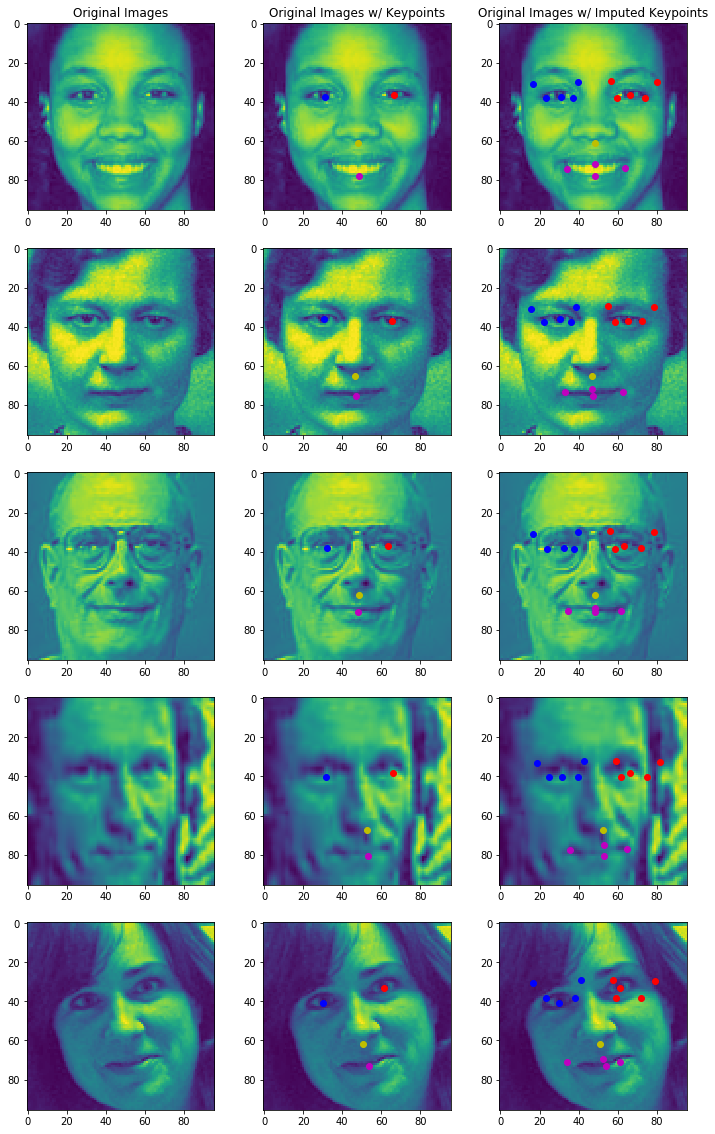

In [288]:
###### Display 5 examples of training data with original keypoints & imputed keypoints
example_nums= [15, 29, 33, 6, 49]
ShowSampleImages(example_nums, P1_train_image_data, P1_train_label_data, imputed_label_data=P1_imputed_label_data)

With the above examples, we can see that for some of the examples, the imputed keypoints appear to be quite close to what we would expect to be the actual keypoints, had we hand-labeled the missing keypoints. This is evident most in the first three examples. However, there are other cases where the missing keypotns imputations are a bit off, such as in the fourth example. And there are some cases where the imputations are very far off due to the nature of the photo, such as the tilting face seen in the last example. This because the facial keypoint imputation feature engineering heavily relies on the layout of keypoints for the average face, most of which are vertically-oriented images facing head-on. To make this more robust, one would want to better capture details related to the arrangement of existing keypoints in order to better-impute the missing keypoints but for the sake of simplicity, we will evaluate whether or not this particular version of facial keypoints imputation can help our modeling.

With the previous implementation of facial keypoint imputation for our priority-1 worst-case scenario, we can generalize the procedure to impute all missing facial keypoints more generally, as done below:

In [289]:
def ImputeAllMissingKeypoints(all_image_data, all_label_data, keypoint_names):
    # Get Data with no missing values for keypoints (to use for learning proper keypoint imputation)
    nomissing_image_data = all_image_data[~np.isnan(all_label_data).any(axis=1)]
    nomissing_label_data = all_label_data[~np.isnan(all_label_data).any(axis=1)]
        
    # Generate encodings map and encodings list
    encodings_map, encoding_list = CreateEncodingMap(all_label_data)
    
    # Create placeholders for all data with imputed keypoints
    original_image_data = np.empty((0, all_image_data.shape[1]), dtype='float')
    original_label_data = np.empty((0, all_label_data.shape[1]), dtype='float')
    imputed_label_data = np.empty((0, original_label_data.shape[1]), dtype='float')
    
    # Iterate through each encoding and impute missing keypoints
    for encoding in encodings_map["encoding"]:    
        # Get the missing data using the filter index for the ith encoding
        missing_kp_idx = [i for i in range(0, len(encoding_list)) if encoding_list[i] == encoding]
        original_image_data_i = all_image_data[missing_kp_idx]
        original_label_data_i = all_label_data[missing_kp_idx]

        # Prep helper data for average matrix computation
        kp_names = [i for i in keypoint_names]
        existing_kp_names = [kp_names[i] for i, c in enumerate(encoding) if c == '1'] # n
        missing_kp_names = [kp_names[i] for i, c in enumerate(encoding) if c == '0'] # m

        # Compute average matrix for x coordinates (produce a nxm matrix)
        existing_kp_names_x = [n for n in existing_kp_names if "_x" in n]
        missing_kp_names_x = [n for n in missing_kp_names if "_x" in n]
        avg_matrix_x_coord = ComputeAvgMatrix(nomissing_label_data, kp_names, existing_kp_names_x, missing_kp_names_x)

        # Compute average matrix for y coordinates (produce another nxm matrix)
        existing_kp_names_y = [n for n in existing_kp_names if "_y" in n]
        missing_kp_names_y = [n for n in missing_kp_names if "_y" in n]
        avg_matrix_y_coord = ComputeAvgMatrix(nomissing_label_data, kp_names, existing_kp_names_y, missing_kp_names_y)

        # Impute x-coordinates of missing keypoints
        imputed_label_data_i = ImputeMissingKeypoints(
            original_label_data_i, kp_names, existing_kp_names_x, missing_kp_names_x, avg_matrix_x_coord)

        # Impute y-coordinates of missing keypoints
        imputed_label_data_i = ImputeMissingKeypoints(
            imputed_label_data_i, kp_names, existing_kp_names_y, missing_kp_names_y, avg_matrix_y_coord)
        
        # Append original & imputed data to aggregated arrays (returned at end)
        original_image_data = np.append(original_image_data, original_image_data_i, axis=0)
        original_label_data = np.append(original_label_data, original_label_data_i, axis=0)
        imputed_label_data = np.append(imputed_label_data, imputed_label_data_i, axis=0)

        #print("Original Image Data Shape: " + str(original_image_data.shape))
        #print("Imputed Label Data Shape: " + str(imputed_label_data.shape))
    
    # Finally, append 
    
    return (original_image_data, original_label_data, imputed_label_data)
    
# Impute all missing keypoints
missing_image_data, missing_label_data, imputed_label_data = ImputeAllMissingKeypoints(train_image_data, train_label_data, keypoint_names)

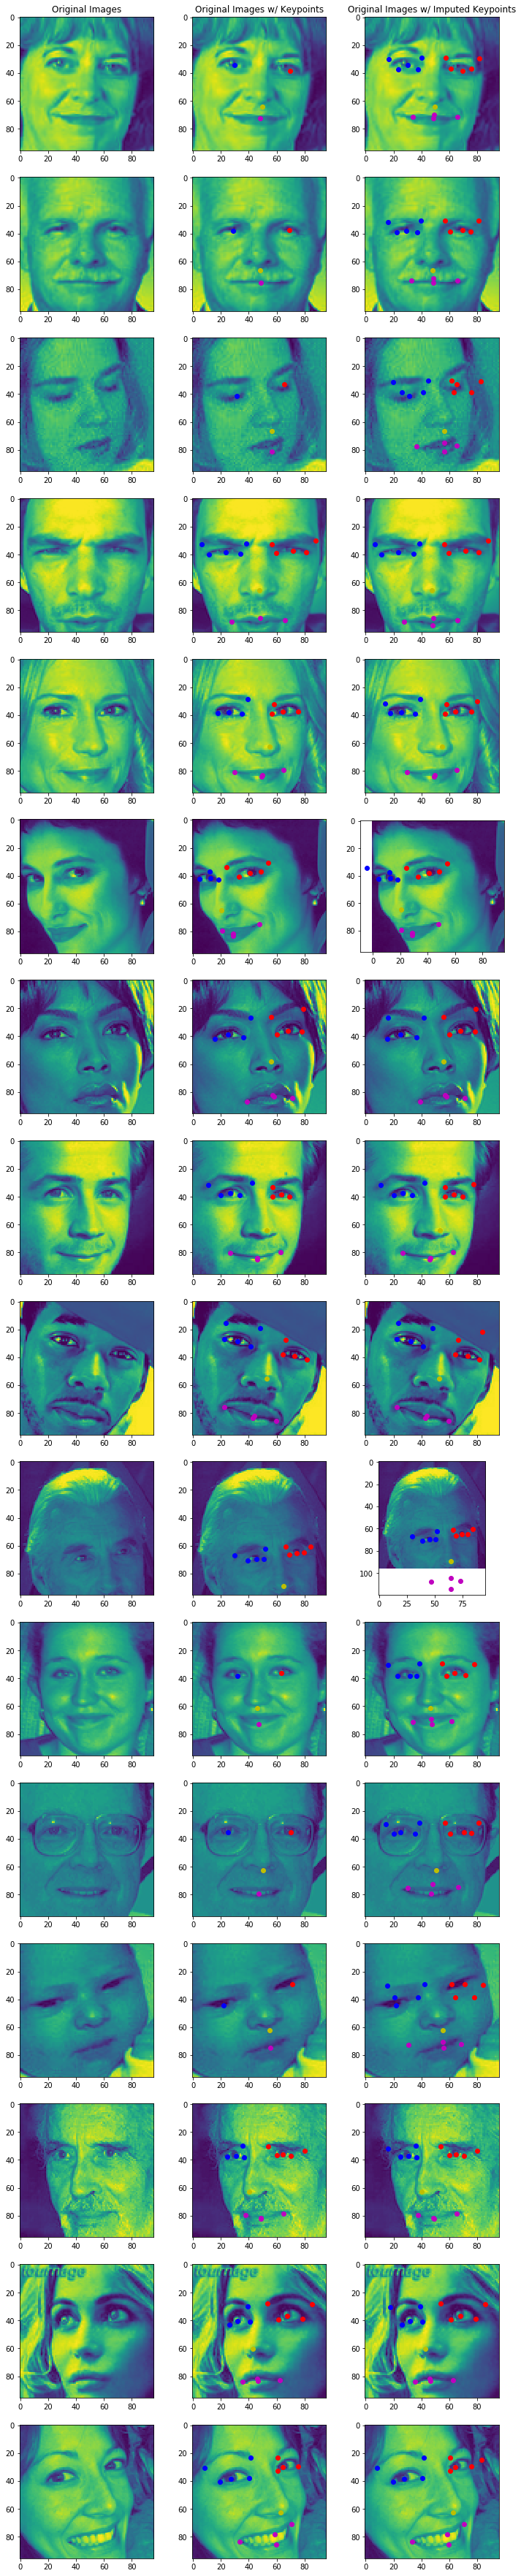

In [290]:
# Display a few examples of training data with original keypoints & imputed keypoints
example_nums = [0, 3804, 3815, 3838, 3847, 3850, 3860, 3884, 3895, 3899, 100, 200, 1200, 3851, 3862, 3882]
ShowSampleImages(example_nums, missing_image_data, missing_label_data, imputed_label_data=imputed_label_data)

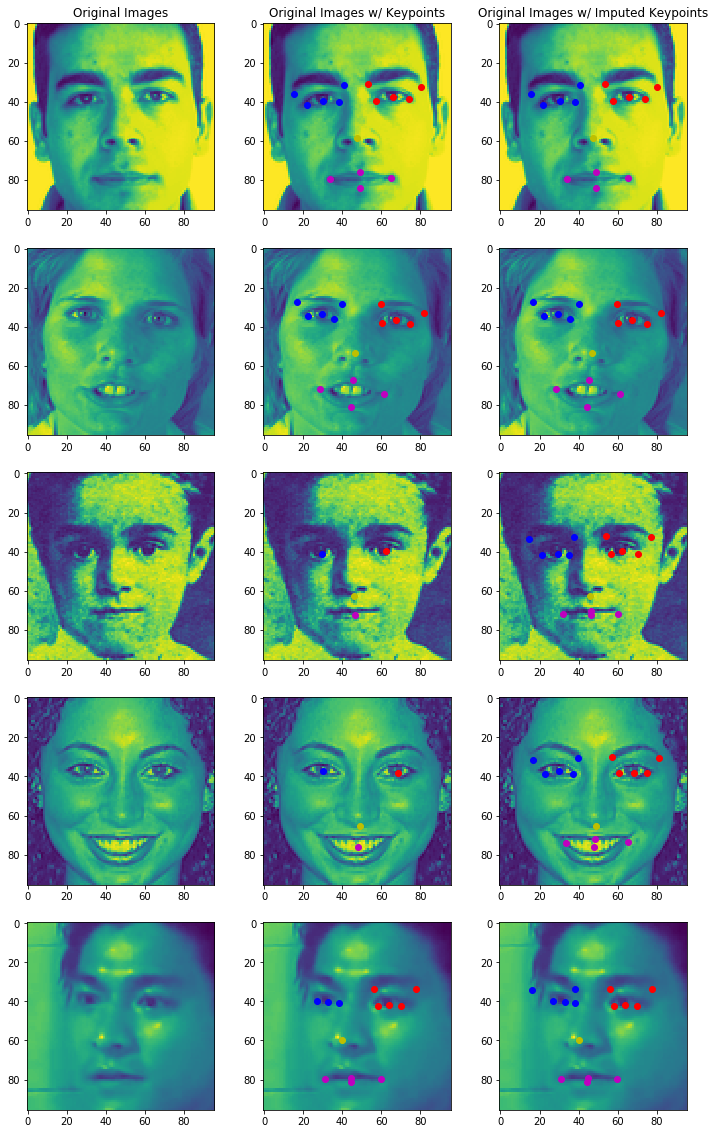

In [291]:
def JoinNonImputedAndImputedLabelData(original_image, original_label, missing_image, missing_label, imputed_label):
    # Get Data with no missing values for keypoints
    nomissing_image = original_image[~np.isnan(original_label).any(axis=1)]
    nomissing_label = original_label[~np.isnan(original_label).any(axis=1)]
    
    # Join images with no missing keypoints with images with missing keypoints (before imputation)
    joined_image = np.concatenate((nomissing_image, missing_image), axis=0)
    
    # Join labels with no missing keypoints with labels with missing keypoints (before imputation)
    joined_label = np.concatenate((nomissing_label, missing_label), axis=0)
    
    # Join labels with no missing keypoints with labels with missing keypoints (after imputation)
    joined_label_imputed = np.concatenate((nomissing_label, imputed_label), axis=0)
    
    return (joined_image, joined_label, joined_label_imputed)

# Create separate training dataset with imputed keypoints
# Replace existing training data with data ordered in same order as imputed labels
# Note that this reordering WILL NOT CHANGE the original training dataset
train_image_data, train_label_data, train_label_data_imputed = JoinNonImputedAndImputedLabelData(
    train_image_data, train_label_data, missing_image_data, missing_label_data, imputed_label_data)

example_nums= [3, 7, 3001, 3504, 5600]
ShowSampleImages(example_nums, train_image_data, train_label_data, imputed_label_data=train_label_data_imputed)

## Augmenting the Dataset with Gaussian Blur

TODO: Add code for applying Gaussian Blur to all images generically

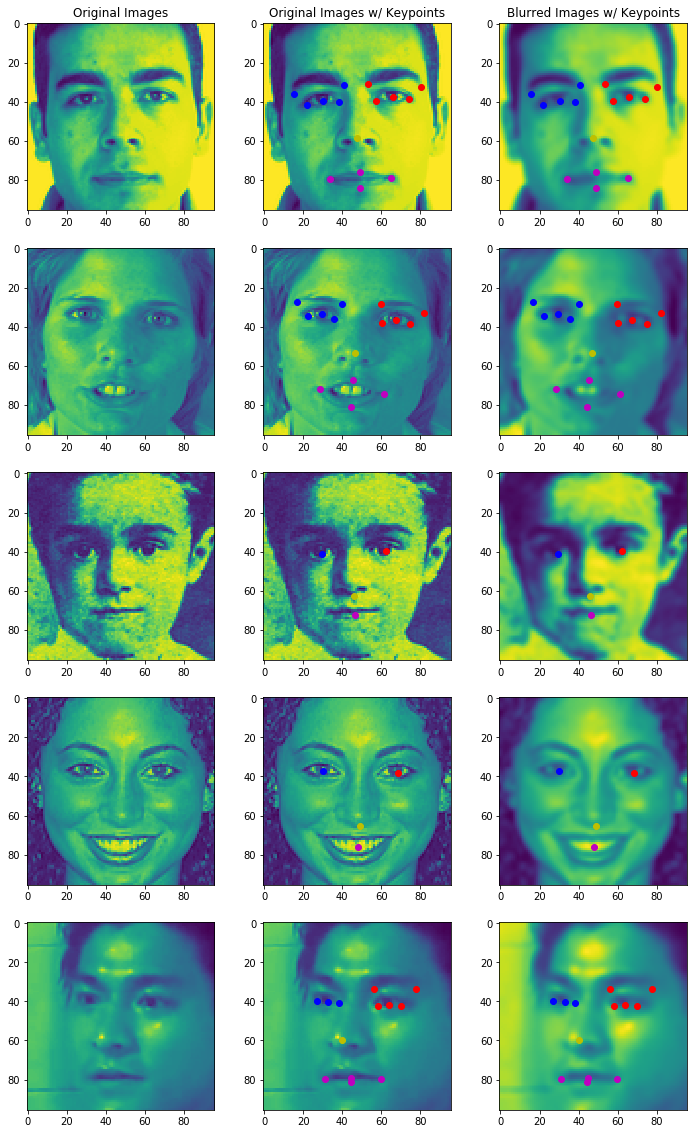

In [292]:
def blur_images(images, sigma=1.5, truncate=1.5):
    # Apply a gaussian blur to the images
    blurred_images = np.copy(images)
    
    # Iterate through each image and blur
    for i in range(0, images.shape[0]):
        image = images[i].reshape(96, 96)
        blurred = skimage.filters.gaussian(image, sigma=sigma, truncate=truncate)
        blurred_images[i] = blurred.reshape(9216)
        
    return blurred_images

train_image_data_blurred = blur_images(train_image_data)
ShowSampleImages(example_nums, train_image_data, train_label_data, blurred_image_data=train_image_data_blurred)

## Augmenting the Dataset with Horizontal Flips


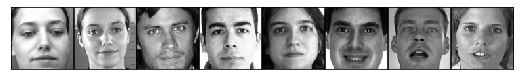

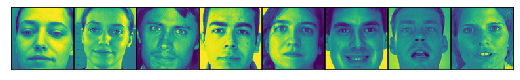

In [293]:
def flip_images(images):
    # Apply a horizontal flip to the images (across the vertical line through the center of the image)
    reshaped_images = images.reshape(images.shape[0],96,96)
    flipped_images = []
    for image in reshaped_images:
        # Flip each image by reversing array defining each pixel row in the image
        image_array = []
        for row in image:
            image_array.append(row[::-1])
        flipped_images.append(image_array)
        
    flipped_array = np.array(flipped_images)
    flipped_images_vectorized = flipped_array.reshape(np.array(flipped_images).shape[0],9216)
    return flipped_images_vectorized

# Flip images in training data
train_image_data_flipped = flip_images(train_image_data)

### this is sanity check, can be deleted.
# Checking the flipped images vs original images
# original images in gray
fig, axes = plt.subplots(1,8,figsize=(9,3), subplot_kw={"xticks":[], "yticks":[]},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_image_data[i].reshape(96,96),cmap="gray")

# flipped images in color
fig, axes = plt.subplots(1,8,figsize=(9,3), subplot_kw={"xticks":[], "yticks":[]},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_image_data_flipped[i].reshape(96,96))

In [294]:
print(train_label_data[0:1])
print()
print(flip_labels(train_label_data[0:1]))

[[ 0.43143316 -0.15924064 -0.42414973 -0.1257861   0.26868449 -0.14497326
   0.60828877 -0.13534759 -0.26163636 -0.12100535 -0.58665241 -0.09232086
   0.21634225 -0.46036364  0.73255615 -0.3886738  -0.23773262 -0.41256684
  -0.77785027 -0.28351872  0.08729412  0.23747594  0.42665241  0.682
  -0.32854545  0.72979679  0.08251337  0.55294118  0.09207487  0.83973262]]

[[ 0.42414973 -0.1257861  -0.43143316 -0.15924064  0.26163636 -0.12100535
   0.58665241 -0.09232086 -0.26868449 -0.14497326 -0.60828877 -0.13534759
   0.23773262 -0.41256684  0.77785027 -0.28351872 -0.21634225 -0.46036364
  -0.73255615 -0.3886738  -0.08729412  0.23747594  0.32854545  0.72979679
  -0.42665241  0.682      -0.08251337  0.55294118 -0.09207487  0.83973262]]


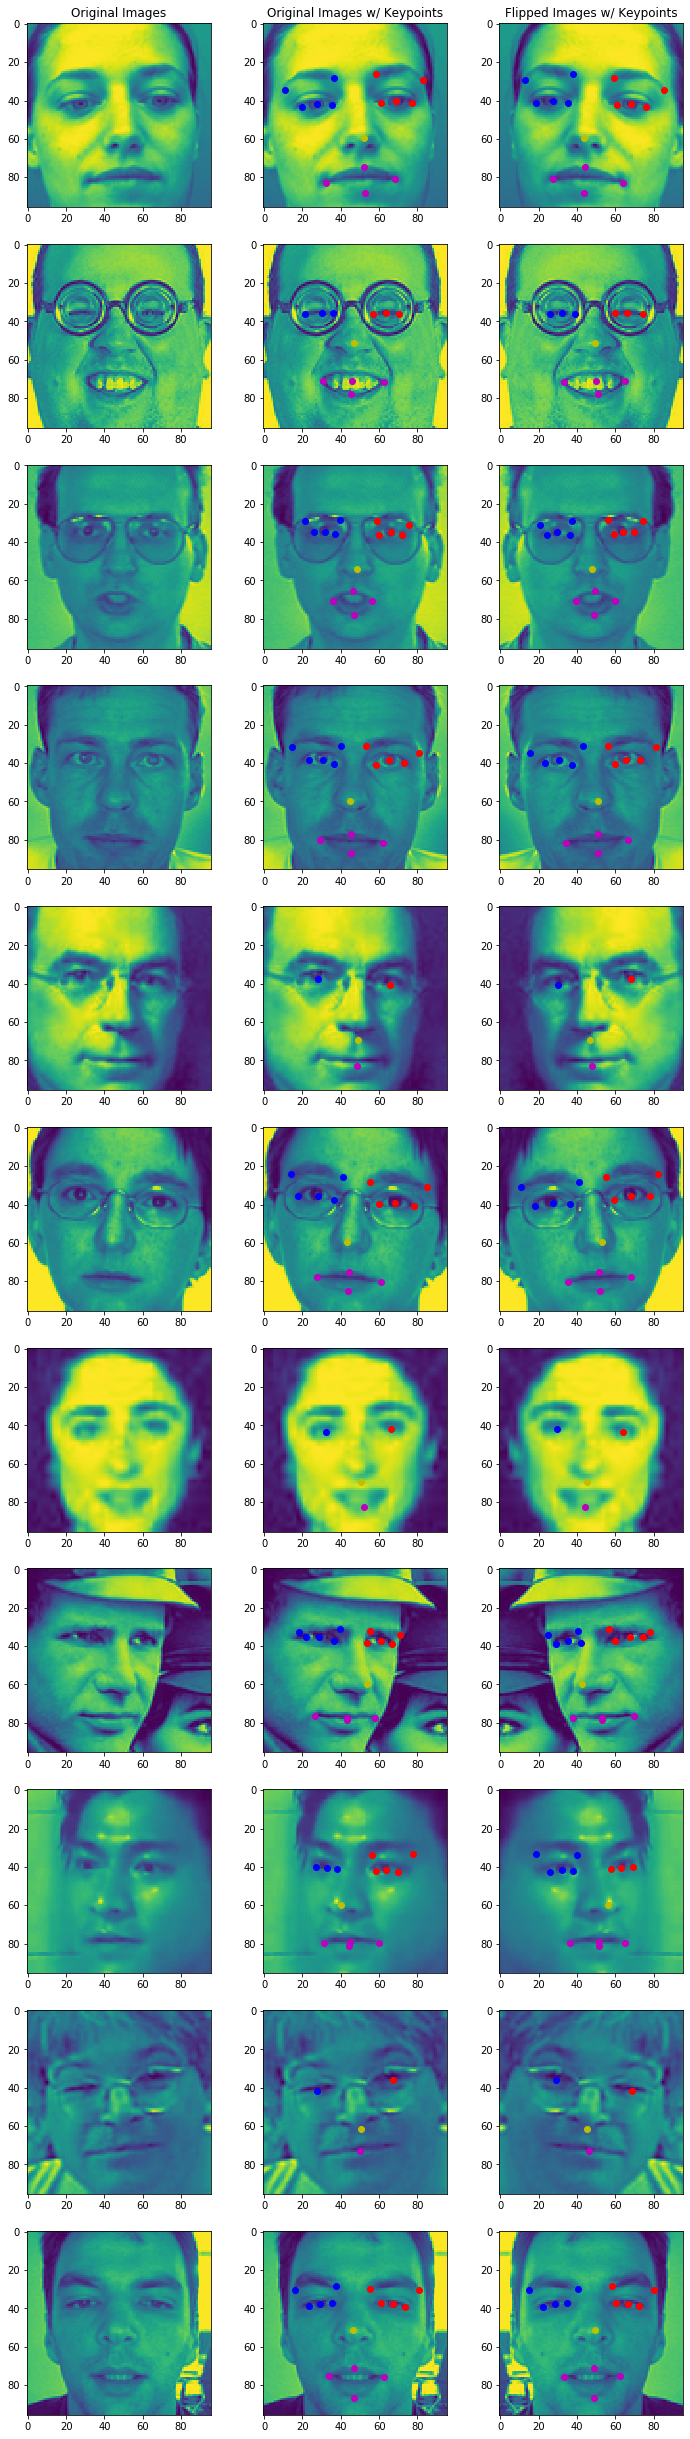

In [295]:
def flip_labels(labels):
    # Flip labels to correspond to a horizontal flip
    idx = [ 2,  3, # left_eye_center -> right_eye_center
            0,  1, # right_eye_center -> left_eye_center
            8,  9, # left_eye_inner_corner -> right_eye_inner_corner
           10, 11, # left_eye_outer_corner -> right_eye_outer_corner
            4,  5, # right_eye_inner_corner -> left_eye_inner_corner
            6,  7, # right_eye_outer_corner -> left_eye_outer_corner
           16, 17, # left_eyebrow_inner_end -> right_eyebrow_inner_end
           18, 19, # left_eyebrow_outer_end  -> right_eyebrow_outer_end
           12, 13, # right_eyebrow_inner_end -> left_eyebrow_inner_end
           14, 15, # right_eyebrow_outer_end -> left_eyebrow_outer_end
           20, 21, # nose_tip -> nose_tip
           24, 25, # mouth_left_corner -> mouth_right_corner
           22, 23, # mouth_right_corner -> mouth_left_corner
           26, 27, # mouth_center_top_lip -> mouth_center_top_lip
           28, 29  # mouth_center_bottom_lip -> mouth_center_bottom_lip
          ]

    # First, reorder the coordinates such that what were once "left" are now "right" and vice-versa
    flipped_labels = labels[:,idx]
    
    # Second, flip the values themselves by negating them
    # (but only the x coordinates, since this is a horizontal flip)
    coordinate_flipping_vector = [-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1]
    final_labels = flipped_labels * coordinate_flipping_vector
    
    return final_labels

# Flip labels in training data
train_label_data_flipped = flip_labels(train_label_data)

# Display 6 examples of training data from Kaggle
example_nums=[0, 5634, 10, 14, 3434, 103, 2234, 145, 5600, 4321, 23]
ShowSampleImages(example_nums, train_image_data, train_label_data, 
                 flipped_image_data=train_image_data_flipped, flipped_label_data=train_label_data_flipped)

In [296]:
# Final merged definition for created flipped augmentations on a given dataset
def flip_images_and_labels(images, labels):
    # First, apply horizontal flip to images
    flipped_images = flip_images(images)
    
    # Next, flip labels to correspond to flipped images
    flipped_labels = flip_labels(labels)
    
    return (flipped_images, flipped_labels)

train_image_data_flipped, train_label_data_flipped = flip_images_and_labels(train_image_data, train_label_data)

## Helper: Preparing Training Datasets

With the three above options for improving our training dataset (kepoint imputations, gaussian blurring, and horizontal flipping), we will want to experiment to see what combination of these improvements will help in improving model quality. Thus, we define the following dataset preparation function to make it easy to generate experimental datasets.

Preparing Training Dataset: imputed=True, blurred=True, flipped=True, prep_images_for_CNN=False, kaggle_submission=False
Not Kaggle Submission...
Imputing...
Blurring...
Flipping...
Final Number of Examples in Training Dataset: 22556


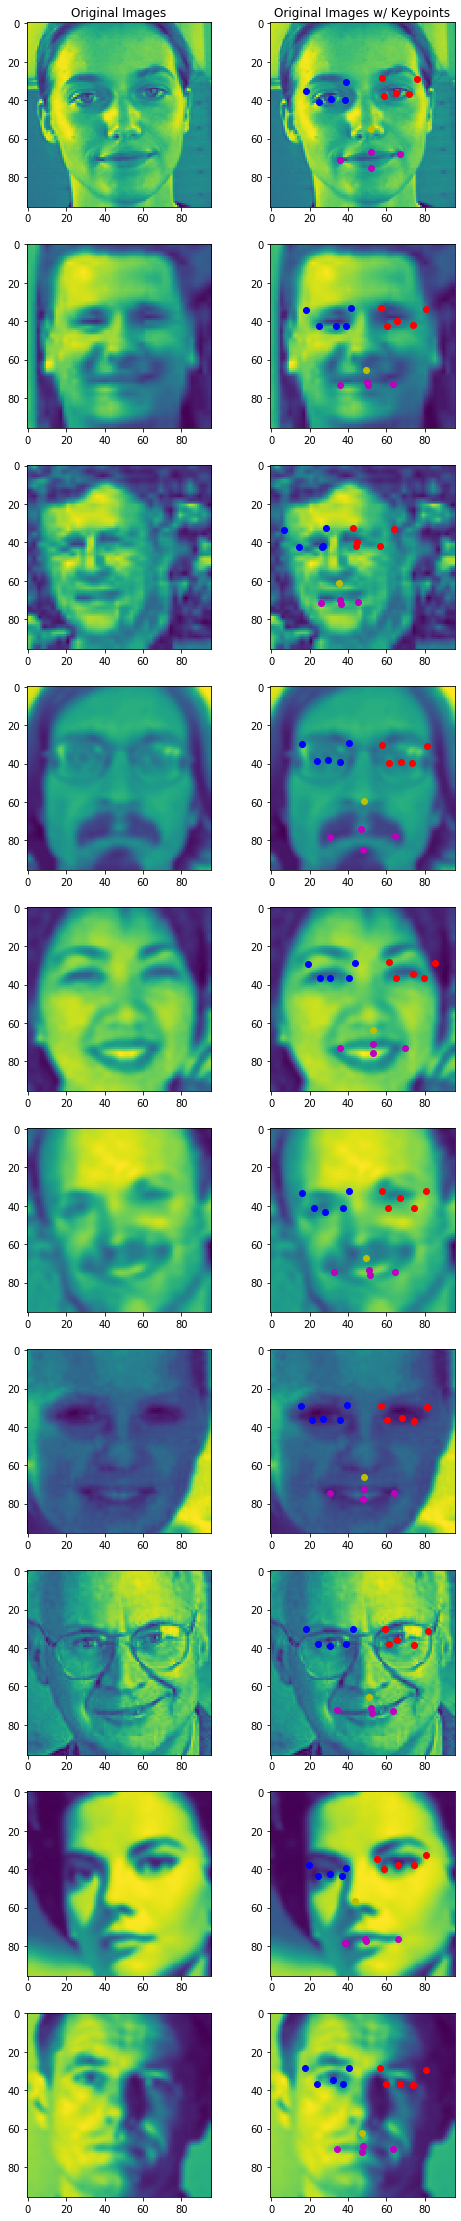

In [297]:
# Example
example_train_image_data, example_train_label_data = PrepareTrainingDataset(
    imputed=True, blurred=True, flipped=True, verbose=True)

# Display 10 examples of training data
example_nums=range(1, 22001, 2200)
example_nums = [i for i in example_nums if i < example_train_image_data.shape[0]]
ShowSampleImages(example_nums, example_train_image_data, example_train_label_data)

# V. Modeling

With potential improvements to the dataset made, we will now attempt to see how these dataset improvements impact our modeling. Starting with a most basic 2-layer neural network and moving to more complex convolutional neural networks, we will evaluate how each of our models fare with our original dataset and the "improved" datasets.

TODO: explore basic modeling with the original dataset that has no missing keypoints (2K examples)
TODO: using these models, try to train the same models using
* original dataset + without keypoints
* original dataset + missing keypoint imputations
* original dataset + augmentations
* original dataset + gaussian blur
* original dataset + augmentations + gaussian blur
* original dataset + missing keypoint imputations + augmentations
* original dataset + missing keypoint imputations + augmentations + gaussian blur

## Helper for Showing Ground Truth and Predictions
To help with qualititative performance evaluation of or models, we define the following function that helps to visualize ground truth keypoints on images ad predicted keypoints on images side by side. This is defined below:

In [298]:
def PlotModelLoss(model_history, log_scale=False):
    train_loss = model_history["loss"]
    dev_loss = model_history["val_loss"]

    plt.plot(dev_loss, linewidth=3, label="dev-loss")
    plt.plot(train_loss, '--', linewidth=3, label="train-loss")
    
    plt.legend()
    plt.grid()
    if(log_scale):
        plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("loss (rmse)")
    plt.show()

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

In [299]:
# custom loss function
backend.is_nan = tf.math.is_nan                       # tf.is_nan
def rmse_error(y_true, y_pred):
    error = backend.switch(tf.math.logical_not(backend.is_nan(y_true)), y_pred - y_true, 0)
    return  backend.mean(backend.abs(error * 48), axis=-1)

## Model 1

In [300]:
# function to predict using model training results
def predict(model, image_data, true_labels=None):
    # Do prediction
    prediction_labels = model.predict(image_data)

    # Get 10 random examples
    random.seed(42)
    example_nums = random.sample(range(0, image_data.shape[0]), 10)
    
    ShowGroundTruthAndPredictions(example_nums, image_data, true_labels, prediction_labels, show_original=True)

In [307]:
backend.is_nan = tf.math.is_nan                       # tf.is_nan
def custom_rmse(y_true, y_pred):
    error = backend.switch(tf.math.logical_not(backend.is_nan(y_true)), y_pred - y_true, 0)
    return  backend.mean(backend.abs(error * 48), axis=-1)

def PrepBaselineModel():
    # Creating a baseline model with no convolutions (two-layer NN)
    model = Sequential()
    model.add(Dense(100, input_dim = 9216))
    model.add(Activation('relu'))
    model.add(Dense(30))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    print(model.summary())
    return model 


In [314]:
def PrepConvModel():
    model = Sequential()

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    
    model.compile(loss = 'mean_squared_error', optimizer='Adam')
    print(model.summary())
    return model

In [ ]:
# Run all Baseline experiments
epochs = 50

model_baseline_original = RunBaselineProcedure(imputed=False, blurred=False, flipped=False, epochs=epochs)
model_baseline_original_blur = RunBaselineProcedure(imputed=False, blurred=True, flipped=False, epochs=epochs)
model_baseline_original_flip = RunBaselineProcedure(imputed=False, blurred=False, flipped=True, epochs=epochs)
model_baseline_original_blur_flip = RunBaselineProcedure(imputed=False, blurred=True, flipped=True, epochs=epochs)

model_baseline_imputed = RunBaselineProcedure(imputed=True, blurred=False, flipped=False, epochs=epochs)
model_baseline_imputed_blur = RunBaselineProcedure(imputed=True, blurred=True, flipped=False, epochs=epochs)
model_baseline_imputed_flip = RunBaselineProcedure(imputed=True, blurred=False, flipped=True, epochs=epochs)
model_baseline_imputed_blur_flip = RunBaselineProcedure(imputed=True, blurred=True, flipped=True, epochs=epochs)


In [ ]:
# Run all Convolutional Experiments
epochs = 50

model_conv_original = RunConvolutionalProcedure(imputed=False, blurred=False, flipped=False, epochs)
model_conv_original_blur = RunConvolutionalProcedure(imputed=False, blurred=True, flipped=False, epochs)
model_conv_original_flip = RunConvolutionalProcedure(imputed=False, blurred=False, flipped=True, epochs)
model_conv_original_blur_flip = RunConvolutionalProcedure(imputed=False, blurred=True, flipped=True, epochs)

model_conv_imputed = RunConvolutionalProcedure(imputed=True, blurred=False, flipped=False, epochs)
model_conv_imputed_blur = RunConvolutionalProcedure(imputed=True, blurred=True, flipped=False, epochs)
model_conv_imputed_flip = RunConvolutionalProcedure(imputed=True, blurred=False, flipped=True, epochs)
model_conv_imputed_blur_flip = RunConvolutionalProcedure(imputed=True, blurred=True, flipped=True, epochs)


In [224]:
model_1_0 = PrepBaselineModel()

train_image_data_1_0, train_label_data_1_0 = PrepareTrainingDataset(
    imputed=True, blurred=False, flipped=False, prep_images_for_CNN=False, verbose=True)
history_1_0 = model_1_0.fit(train_image_data_1_0, train_label_data_1_0, epochs=10, validation_data=(dev_image_data, dev_label_data))

NameError: name 'PrepBaselineModel' is not defined

In [211]:
ex_true_labels = train_label_data[4000:4010, :]
ex_images = train_image_data[4000:4010, :]
ex_prediction_labels = model_1_0.predict(ex_images)

idx = np.argwhere(np.isnan(ex_true_labels))
for i in idx:
    ex_true_labels[i[0], i[1]] = ex_prediction_labels[i[0], i[1]] # to enable 0 error for nan values
error = np.subtract(ex_prediction_labels, ex_true_labels)
rmse = np.mean(np.abs(error * 48), axis=1)
print(rmse)

ex_example_nums = list(np.negative(rmse).argsort()[-3:][::-1]) 
ex_example_nums

[0.80962585 0.81642186 1.64149576 0.76759445 2.73471781 0.79832194
 1.57052795 0.83907803 0.42490413 0.44696981]


[8, 9, 3]

(1410,)


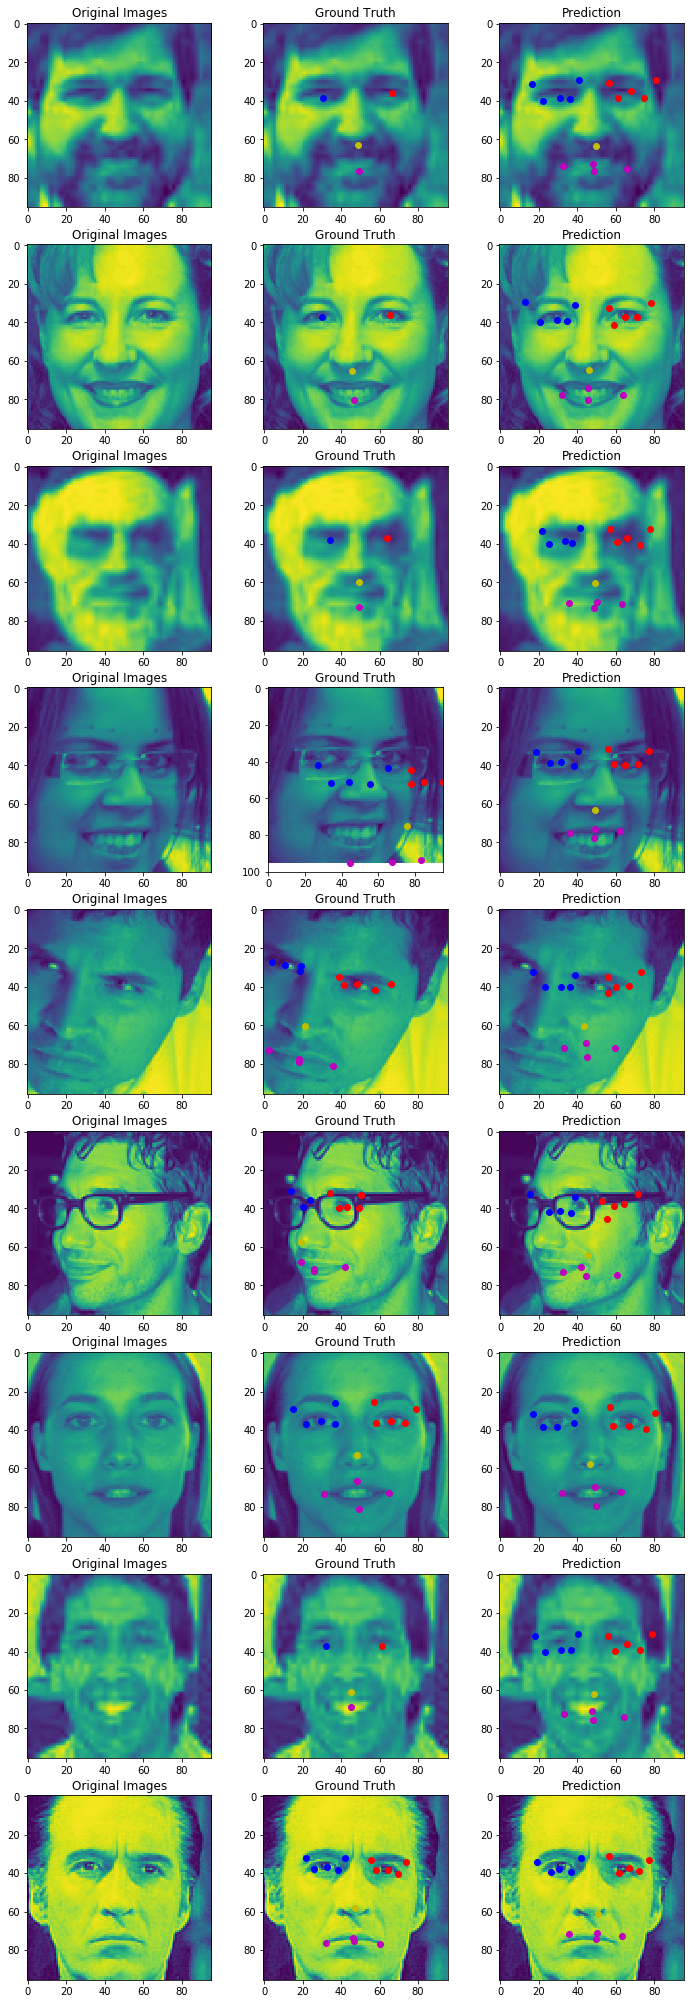

In [215]:
predict(model_1_0, dev_image_data, dev_label_data)

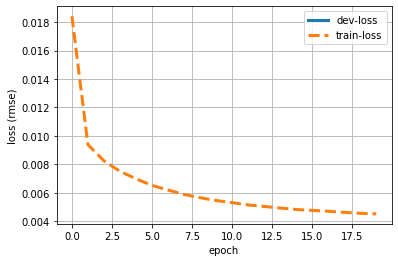

In [118]:
PlotModelLoss(history_1_0.history)

### simplified kaggle model

# Submitting to Kaggle

In [303]:
def ShowGroundTruthAndPredictions(example_nums, image_data, ground_truth_labels, prediction_labels, show_original=False, prep_labels=True):
    
    # Reshape image data as needed from CNN format
    if (image_data.shape == (image_data.shape[0], 96, 96, 1)):
        # Reshape images to vectorized form
        image_data = image_data.reshape(image_data.shape[0], 96*96)
    
    # Figure out figure dimensions
    num_examples = len(example_nums)
    num_col = (int(ground_truth_labels is not None) + int(prediction_labels is not None) + int(show_original))
    f, images = plt.subplots(num_examples,num_col, figsize=(4*num_col,4*num_examples))

    def PrepImageData(image):
        return image.reshape(96, 96) * 255
    
    def PrepLabelData(label, prep_label):
        if (prep_label):
            return (label * 96/2.0) + 96/2.0
        else:
            return label
    
    def PlotExample(row, col, image, label, title, prep_label=True):
        # Plot image
        images[row, col].imshow(PrepImageData(image))
        images[row, col].set_title(title)
            
        # Plot keypoints over image
        if (label is not None):
            for kp_idx in range(0, 15):
                colors = ['r', 'b', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'y', 'm', 'm', 'm', 'm']
                if (not np.isnan(label[2 * kp_idx])):
                    images[row, col].plot(PrepLabelData(label[2 * kp_idx], prep_label), 
                                          PrepLabelData(label[2 * kp_idx + 1], prep_label), 'o', color=colors[kp_idx])
    
    for j in range(0, num_examples):
        example_idx = example_nums[j]
        
        idx = -1
        
        # Plot original image with no keypoints
        if (show_original):
            idx = idx + 1
            PlotExample(j, idx, image_data[example_idx], None, "Original Images", prep_labels)

        # Plot image with ground truth keypoints
        if (ground_truth_labels is not None):
            idx = idx + 1
            PlotExample(j, idx, image_data[example_idx], ground_truth_labels[example_idx], "Ground Truth", prep_labels)
        
        if (prediction_labels is not None):
            # Plot image with predicted keypoints
            idx = idx + 1
            PlotExample(j, idx, image_data[example_idx], prediction_labels[example_idx], "Prediction", prep_labels)            

In [309]:
def PrepareImagesForCNN(images):
    return images.reshape(images.shape[0], 96, 96, 1)

# Function to help prepare the training dataset for training
# If all parameter are false, returns the original training dataset we generated at the start
# If prep_conv_images is true, prepares images for a convolutional neural network training
def PrepareTrainingDataset(imputed=False, blurred=False, flipped=False,
                           prep_images_for_CNN=False, verbose=False, kaggle_submission=False):
    if (verbose):
        print("Preparing Training Dataset: imputed=" + str(imputed) + ", blurred=" + str(blurred) + 
              ", flipped=" + str(flipped) + ", prep_images_for_CNN=" + str(prep_images_for_CNN) + 
              ", kaggle_submission=" + str(kaggle_submission))
    
    # Start from original dataset
    if (not kaggle_submission):
        if (verbose):
            print("Not Kaggle Submission...")
        final_train_image_data = train_image_data
        final_train_label_data = train_label_data
    else:
        # final kaggle submission will require training on both our "train" dataset and our "dev" dataset
        # (i.e. the full kaggle training dataset)
        if (verbose):
            print("Kagle Submission...")
        final_train_image_data = np.concatenate((train_image_data, dev_image_data), axis=0)
        final_train_label_data = np.concatenate((train_label_data, dev_label_data), axis=0)
    
    if (imputed):
        # Use dataset with imputed keypoints
        if (verbose):
            print("Imputing...")
        if (not kaggle_submission):
            # Use already imputed data on training set
            final_train_label_data = train_label_data_imputed
        else:
            # Prepare imputed data on dev set (hasn't been done before)
            dev_missing_image, dev_missing_label, dev_imputed_label = ImputeAllMissingKeypoints(
                dev_image_data, dev_label_data, keypoint_names
            )
            dev_image, dev_label, dev_label_imputed = JoinNonImputedAndImputedLabelData(
                dev_image_data, dev_label_data, dev_missing_image, dev_missing_label, dev_imputed_label
            )
            final_train_image_data = np.concatenate((train_image_data, dev_image), axis=0)
            final_train_label_data = np.concatenate((train_label_data_imputed, dev_label_imputed), axis=0)
        
    if (blurred):
        # Augment dataset with blurred images
        if(verbose):
            print("Blurring...")
        blurred_images = blur_images(final_train_image_data)
        final_train_image_data = np.concatenate((final_train_image_data, blurred_images), axis=0)
        final_train_label_data = np.concatenate((final_train_label_data, final_train_label_data), axis=0)
        
    if (flipped):
        # Augment dataset with flipped images and flipped keypoints
        if(verbose):
            print("Flipping...")
        flipped_images, flipped_labels = flip_images_and_labels(final_train_image_data, final_train_label_data)
        final_train_image_data = np.concatenate((final_train_image_data, flipped_images), axis=0)
        final_train_label_data = np.concatenate((final_train_label_data, flipped_labels), axis=0)
        
    if (prep_images_for_CNN):
        # Reshape images to prepare for CNN training
        if(verbose):
            print("Reshaping...")
        final_train_image_data = PrepareImagesForCNN(final_train_image_data) 
        
    if (verbose):
        print("Final Number of Examples in Training Dataset: " + str(final_train_image_data.shape[0]))
        
    return (final_train_image_data, final_train_label_data)

Baseline Procedure Call: Imputed=True Blurred=True Flipped=False Epochs=5 Kaggle Submission=True
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 100)               921700    
_________________________________________________________________
activation_31 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
Preparing Training Dataset: imputed=True, blurred=True, flipped=False, prep_images_for_CNN=False, kaggle_submission=True
Kagle Submission...
Imputing...
Blurring...
Final Number of Examples in Training Dataset: 14098
Train on 14098 samples, validate on 1410 samples
Epoch 1/5

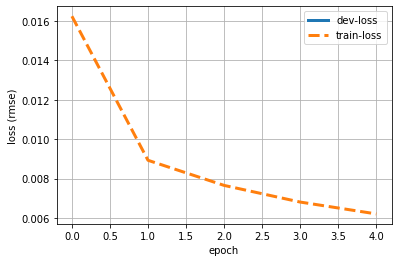

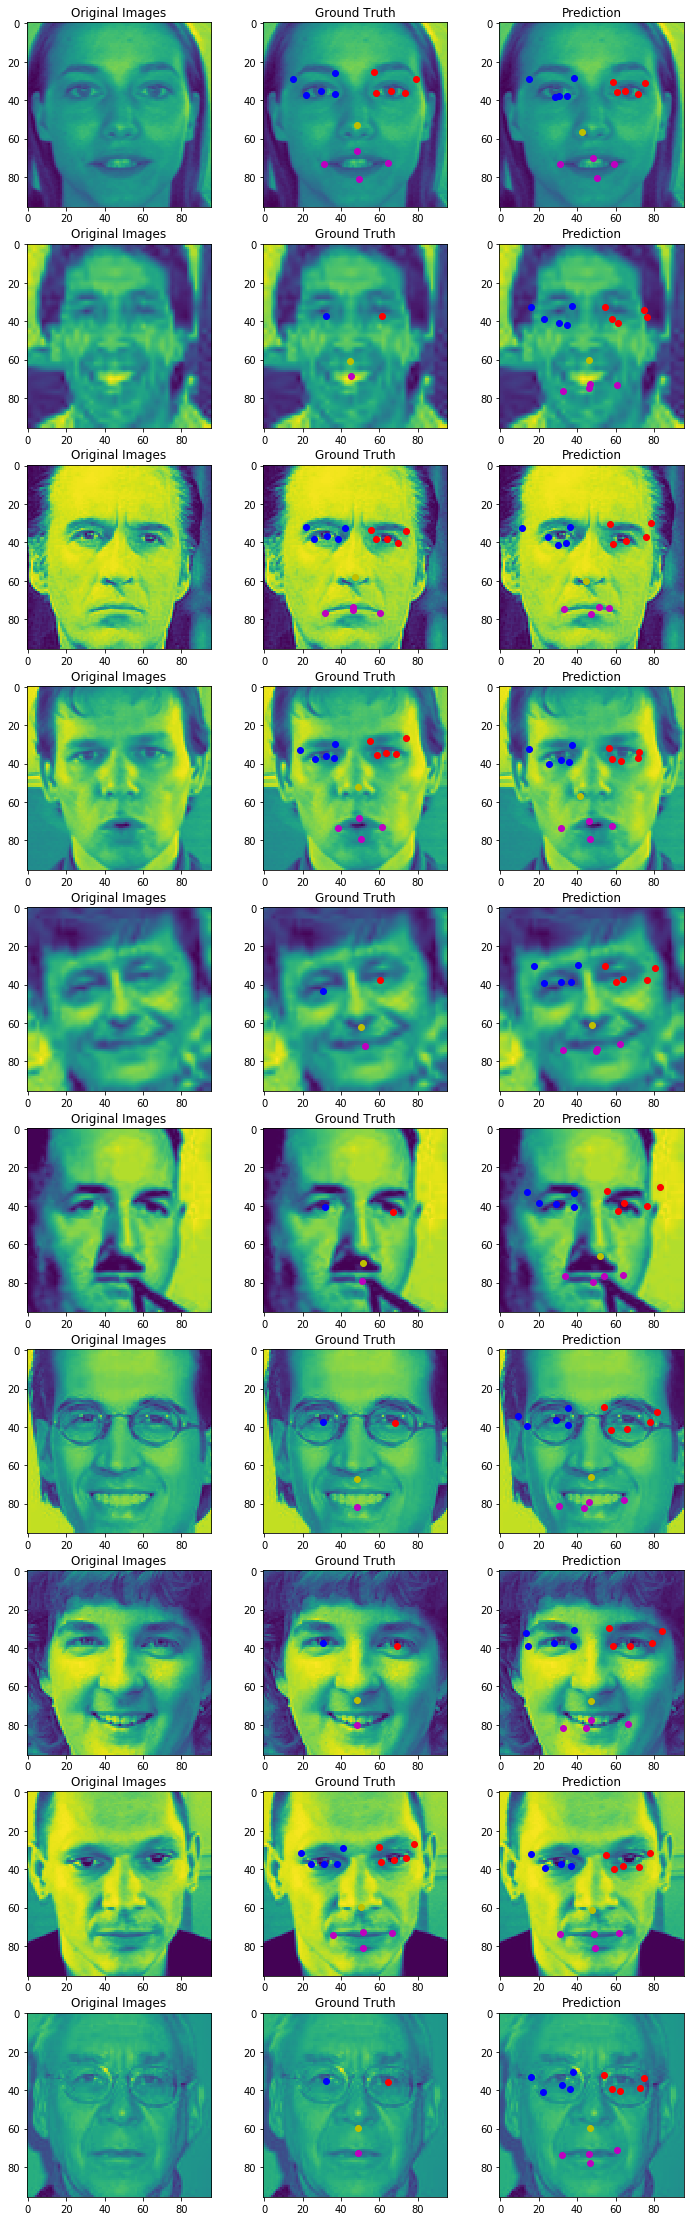

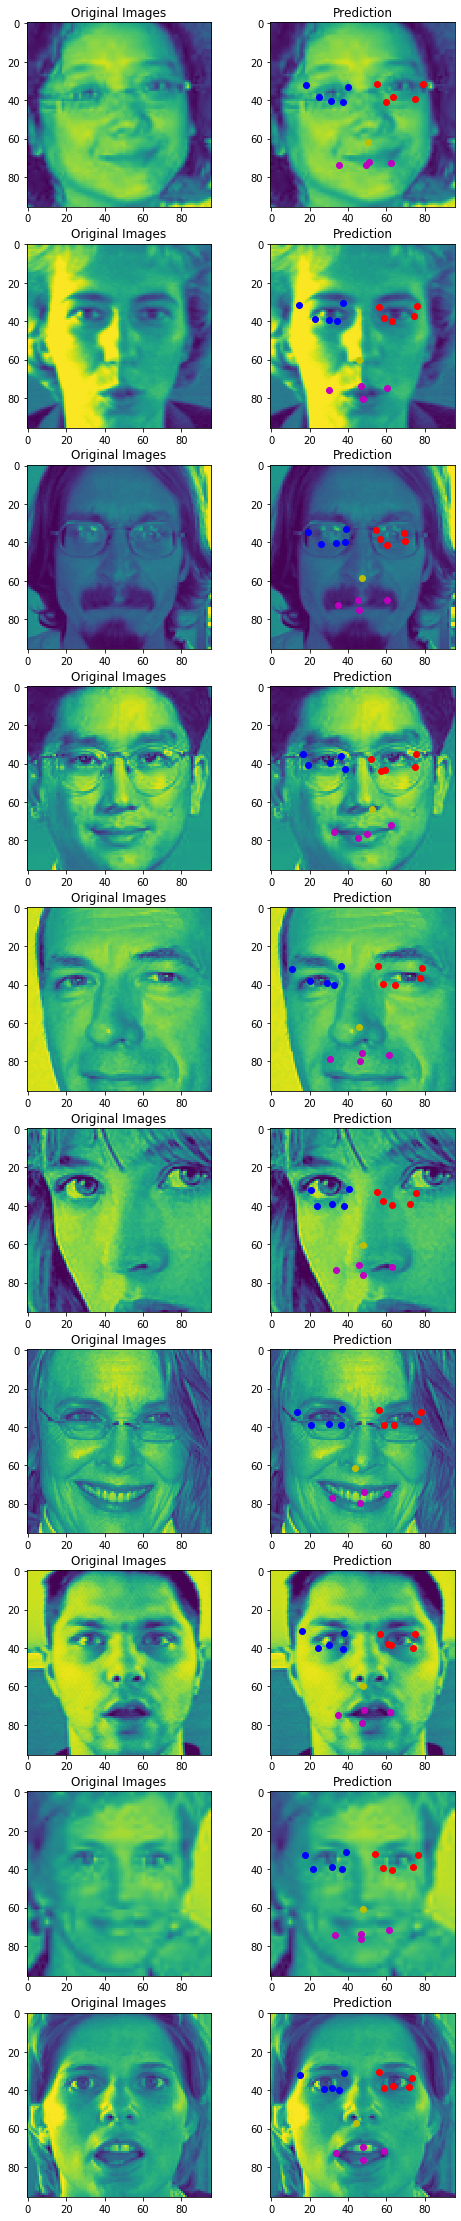

In [312]:
# Run a single Baseline Experiment
def RunBaselineProcedure(imputed, blurred, flipped, epochs, kaggle_submission=False):
    print("Baseline Procedure Call: Imputed=" + str(imputed) + 
          " Blurred=" + str(blurred) + 
          " Flipped=" + str(flipped) + 
          " Epochs=" + str(epochs) +
          " Kaggle Submission=" + str(kaggle_submission))
    
    model = PrepBaselineModel() # PrepConvModel()

    # Prep training data
    train_image_data_p, train_label_data_p = PrepareTrainingDataset(
        imputed=imputed, blurred=blurred, flipped=flipped, 
        prep_images_for_CNN=False, kaggle_submission=kaggle_submission, verbose=True)

    # Train model and get history
    history = model.fit(train_image_data_p, train_label_data_p, epochs=epochs, 
                        validation_data=(dev_image_data, dev_label_data))

    # Plot loss
    PlotModelLoss(history.history)
    
    # Predict on dev data
    predict(model, dev_image_data, true_labels=dev_label_data)
    
    return model

model_test = RunBaselineProcedure(imputed=True, blurred=True, flipped=False, epochs=5, kaggle_submission=True)

In [316]:
# Run a single Convolutional Experiment
def RunConvolutionalProcedure(imputed, blurred, flipped, epochs, kaggle_submission=False):
    print("Convolutional Procedure Call: Imputed=" + str(imputed) + 
          " Blurred=" + str(blurred) + 
          " Flipped=" + str(flipped) + 
          " Epochs=" + str(epochs) +
          " Kaggle Submission=" + str(kaggle_submission))
    
    model = PrepConvModel()

    # Prep training data
    train_image_data_p, train_label_data_p = PrepareTrainingDataset(
        imputed=imputed, blurred=blurred, flipped=flipped, 
        prep_images_for_CNN=True, verbose=True, kaggle_submission=kaggle_submission)

    # Train model and get history
    history = model.fit(train_image_data_p, train_label_data_p, epochs=epochs, 
                        validation_data=(PrepareImagesForCNN(dev_image_data), dev_label_data))

    # Plot loss
    PlotModelLoss(history.history)
    
    # Predict on dev data
    predict(model, PrepareImagesForCNN(dev_image_data), true_labels=dev_label_data)
    
    # Predict on test data
    predict(model, PrepareImagesForCNN(test_image_data), true_labels=None)
    
    return model

model_test = RunConvolutionalProcedure(imputed=True, blurred=False, flipped=False, epochs=10, kaggle_submission=True)

Convolutional Procedure Call: Imputed=True Blurred=False Flipped=False Epochs=2 Kaggle Submission=False


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [318]:
def PrepKaggleSubmission(model, cnn=True):
    # Predict on test set and convert predictions to 0-96 coordinate space
    if (cnn):
        prediction_labels = model.predict(PrepareImagesForCNN(test_image_data))
    else:
        prediction_labels = model.predict(test_image_data)
    prediction_labels = (prediction_labels * 96/2.0) + 96/2.0
    
    #ShowGroundTruthAndPredictions([0, 1, 2, 3, 4], test_image_data, None, prediction_labels, 
    #                              show_original=True, prep_labels=False)
    
    # Get lookup table and construct lists of columns for Kaggle Submission
    id_lookup_table = pd.read_csv('data/IdLookupTable.csv') # Get the id lookup table to prep for submission
    keypoint_names_list = list(id_lookup_table['FeatureName']) # Get keypoint names list
    imageIds_list = list(id_lookup_table['ImageId'] - 1) # Get indicies of imageIds (start at 1, want to start at 0)
    rowIds_list = list(id_lookup_table['RowId'])
    
    # Get order of keypoints in prediction according to the original kaggle competition data
    keypoint_names = kaggle_competition_training_data.columns[0:30]
    keypoint_names = [i for i in keypoint_names]
    
    # Get the index of the keypoint (between 0-29 inclusive) that we want to collect for each rowId
    keypoint_idx_list = [keypoint_names.index(kp_name) for kp_name in keypoint_names_list]
    
    # Get the pairs of ImageId and keypoint indicies that we want predictions for
    # These pairs will correspond to the predicted labels from above
    predicted_locations = []
    for image_id, keypoint_idx in zip(imageIds_list, keypoint_idx_list):
        prediction = prediction_labels[image_id, keypoint_idx]
        predicted_locations.append(prediction)
        
    # With these predictions in place, construct the submission csv,
    # which is formatted as [RowId, Location]
    submission_df = pd.DataFrame()
    submission_df['RowId'] = rowIds_list
    submission_df['Location'] = predicted_locations
    
    # Save submission to csv
    submission_df.to_csv(path_or_buf = "FacialKeypointsDetection_RnD_Submission.csv")
    
PrepKaggleSubmission(model_test, True)